In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pickle, sys, os, time, random, warnings, gc
from tqdm import tqdm

import heapq
from collections import deque
from operator import itemgetter

import tensorflow as tf
from tensorflow import data
from tensorflow import keras
from keras.layers import CenterCrop, Lambda, Resizing
from keras.layers import BatchNormalization, Dense, Dropout, GlobalAveragePooling2D

from sklearn.metrics import *
from sklearn.model_selection import KFold

import statsmodels.api as sm
from scipy import stats
from scipy.interpolate import interp1d
from scipy.stats import ttest_ind, chi2_contingency

from utils.image_viz import *
warnings.filterwarnings('ignore')

# Reproducibility
SEED = 98
def seed_everything():
    random.seed(SEED)
    np.random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    tf.random.set_seed(SEED)

seed_everything()

# Tensorflow Device Setup
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['TF_ENABLE_ONE_DNN_OPTS'] = '0'
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

physical_devices = tf.config.list_physical_devices('GPU')
try: tf.config.experimental.set_memory_growth(physical_devices[0], True)
except: pass

AUTOTUNE = 12

2024-11-12 14:45:08.729579: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 14:45:08.749186: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-12 14:45:09.056382: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-12 14:45:09.452617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

# **Load Dataset**

### **1. Load Dataset**

In [2]:
# File Paths
DATASET_FILENAME = 'dataset/ALL/dataset.pkl'
PATIENT_ID_TVAL_FILENAME = 'dataset/ALL/patient_id_tval.pkl'
PATIENT_ID_TEST_FILENAME = 'dataset/ALL/patient_id_test.pkl'

# Patient ID List
patient_id_tval = pickle.load(open(PATIENT_ID_TVAL_FILENAME, 'rb'))
patient_id_test = pickle.load(open(PATIENT_ID_TEST_FILENAME, 'rb'))

# Load Dataset
with open(DATASET_FILENAME, 'rb') as f:
    ds = pickle.load(f)
    X_tval, y_tval = ds['X_tval'], ds['y_tval']
    X_test, y_test = ds['X_test'], ds['y_test']
    del ds

# Print Dataset Specifications
print(len(patient_id_tval), X_tval.shape, y_tval.shape)
print(len(patient_id_test), X_test.shape, y_test.shape)

6880 (6880, 224, 112, 3) (6880,)
765 (765, 224, 112, 3) (765,)


In [3]:
INPUT_SHAPE = (224, 112)
BATCH_SIZE = 32
BUFFER_PREFETCH = 3

augment_test = tf.keras.Sequential([
    Lambda(lambda x: tf.cast(x, dtype=tf.float32)),
    CenterCrop(height=int(INPUT_SHAPE[0] * 0.95), width=int(INPUT_SHAPE[1] * 0.95)),
    Resizing(height=INPUT_SHAPE[0], width=INPUT_SHAPE[1])
])

def PrepareDataset_TEST(ds):
    ds = ds.map(lambda X, y: (augment_test(X), y), num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(buffer_size=BUFFER_PREFETCH)

# Test DataLoader
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
ds_test = PrepareDataset_TEST(ds_test)

2024-11-12 14:45:09.632296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-12 14:45:09.632423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-12 14:45:09.632469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### **2. Visualize Data Samples**

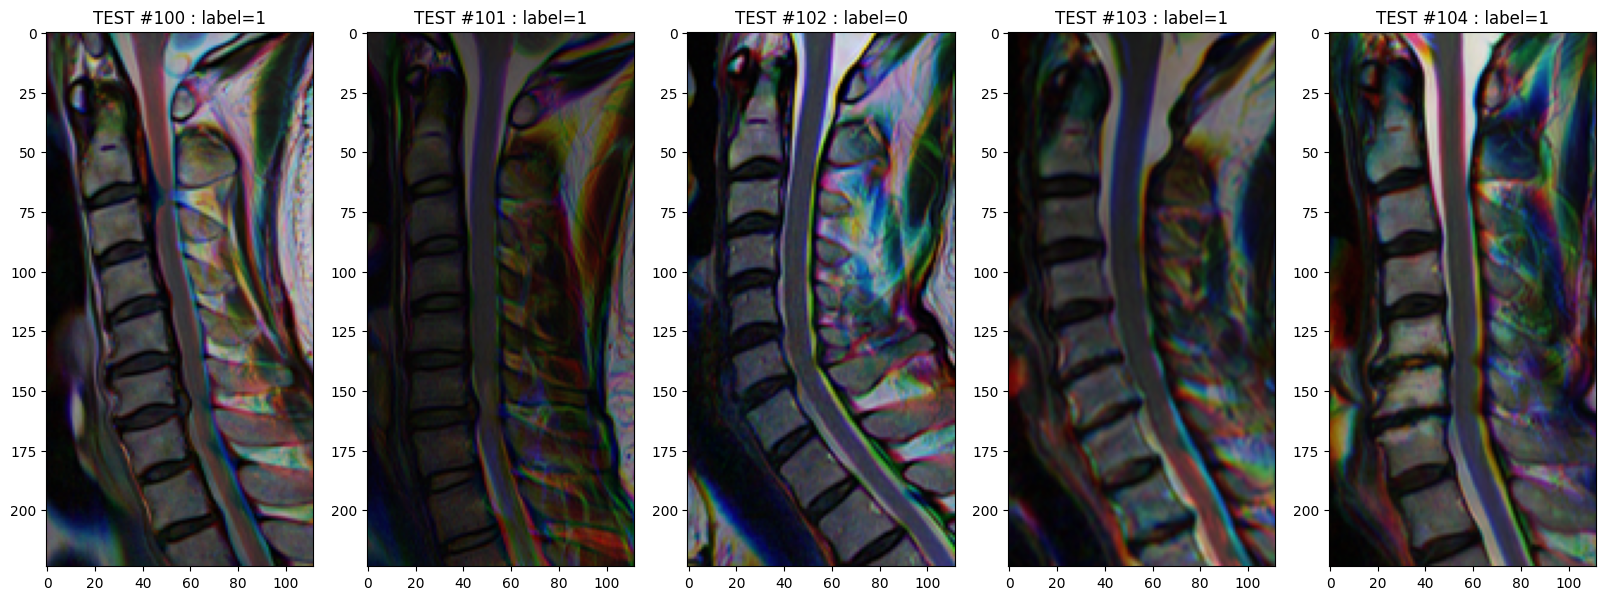

In [4]:
id_list = list(range(100, 105))
image_list, label_list = [], []
for id in id_list:
    image_list.append(X_test[id, :, :].astype(np.uint8))
    label_list.append(f'TEST #{id} : label={y_test[id]}')

ShowImages(image_list, label_list, figsize=(4, 8), ncols=5)

# **Run Models**

### **1. Find Trial Directory**

In [5]:
STUDY_DIR = {
    'ResNet50'         : 'fine_tune_3/ResNet50_241021_00',
    'VGG16'            : 'fine_tune_1/VGG16_241016_01',
    'MobileNetV3'      : 'fine_tune_3/MobileNetV3Large_241020_00',
    'EfficientNetV2'   : 'fine_tune_3/EfficientNetV2S_241018_00',
}

In [6]:
def sorted_trial_dir(study_dir):
    result = []
    for trial_folder in sorted(os.listdir(study_dir), reverse=True):
        if trial_folder.startswith('auc=0.'):
            result.append(f'{study_dir}/{trial_folder}')

    return result

TRIAL_DIR = {arch : sorted_trial_dir(STUDY_DIR[arch])[0] for arch in STUDY_DIR.keys()}
for arch in TRIAL_DIR.keys():
    print(arch, ':', TRIAL_DIR[arch])

ResNet50 : fine_tune_3/ResNet50_241021_00/auc=0.9427_unfr=all_batch=4_optim=Adam_lr=0.00002_pat=5_factor=0.159
VGG16 : fine_tune_1/VGG16_241016_01/auc=0.9521_unfr=15_batch=8_optim=Adam_lr=0.00007_pat=5_factor=0.082
MobileNetV3 : fine_tune_3/MobileNetV3Large_241020_00/auc=0.9485_unfr=all_batch=4_optim=Adam_lr=0.00021_pat=3_factor=0.106
EfficientNetV2 : fine_tune_3/EfficientNetV2S_241018_00/auc=0.9460_unfr=all_batch=4_optim=Adam_lr=0.00005_pat=4_factor=0.188


### **2. Run Each Model**

In [7]:
def run_model(arch, ds_test):
    trial_dir = TRIAL_DIR[arch]
    HPARAMS_ARCH_FILENAME = f'{trial_dir}/hparams_arch.pkl'
    hparams_arch = pickle.load(open(HPARAMS_ARCH_FILENAME, 'rb'))

    BASE_MODEL_FILENAME         = hparams_arch['BASE_MODEL_FILENAME']
    ARCHITECTURE                = BASE_MODEL_FILENAME.split('/')[1]
    FF_LAYER_LIST               = hparams_arch['FF_LAYER_LIST']
    DROPOUT_RATE                = hparams_arch['DROPOUT_RATE']

    # Load Base Model
    if arch == 'ResNet50':
        base_model = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
    elif arch == 'VGG16':
        base_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')
    elif arch == 'EfficientNetV2':
        base_model = keras.applications.efficientnet_v2.EfficientNetV2S(include_top=False, weights='imagenet')
    elif arch == 'MobileNetV3':
        base_model = keras.applications.MobileNetV3Large(include_top=False, weights='imagenet')

    # Add FF Layers
    out = GlobalAveragePooling2D()(base_model.output)
    for n_node in FF_LAYER_LIST:
        out = Dropout(rate=DROPOUT_RATE, name=f'CustomDrop_{n_node}')(out)
        out = Dense(n_node, activation='relu', name=f'CustomFF_{n_node}')(out)
        out = BatchNormalization(name=f'CustomBN_{n_node}')(out)

    # Final Output
    out = Dropout(rate=DROPOUT_RATE, name='CustomDrop_final')(out)
    out = Dense(1, name='CustomFF_final')(out)

    # Define Model
    model = keras.Model(inputs=[base_model.input], outputs=[out])

    # Run Model
    y_pred_proba_list = []

    for i_fold in range(3):
        weight_cache = f'{trial_dir}/weights_{i_fold}.hdf5'
        model.load_weights(weight_cache)

        y_pred_logit = model.predict(ds_test)
        y_pred_proba = 1. / (1. + np.exp(-y_pred_logit))
        y_pred_proba_list.append(y_pred_proba)

    y_pred_proba_list = np.array(y_pred_proba_list)
    y_pred_proba = np.mean(y_pred_proba_list, axis=0)

    return y_pred_proba

In [8]:
y_pred = {}
for arch in TRIAL_DIR.keys():
    print(f'TESTING [{arch}] ...')
    y_pred[arch] = run_model(arch, ds_test)
    print()

y_pred['Ensemble'] = sum([y_pred[arch] for arch in TRIAL_DIR.keys()]) / len(TRIAL_DIR.keys())
#y_pred['Ensemble_max'] = np.max(np.array([y_pred[arch] for arch in TRIAL_DIR.keys()]), axis=0)

TESTING [ResNet50] ...


2024-11-12 14:45:11.332112: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-12 14:45:11.429824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


24/24 [==============================] - 0s 5ms/step

TESTING [VGG16] ...
24/24 [==============================] - 0s 11ms/step

TESTING [MobileNetV3] ...


24/24 [==============================] - 0s 3ms/step

TESTING [EfficientNetV2] ...
24/24 [==============================] - 0s 6ms/step



# **Classifier Performance**

### **1. ROC Curves**

In [9]:
# Youden J Point
def YoudenJ(y_true, y_pred_proba):
    fpr, tpr, thres = roc_curve(y_true, y_pred_proba)
    
    arr = [t + (1 - f) for f, t in zip(fpr, tpr)]
    idx, _ = max(enumerate(arr), key=itemgetter(1))

    return fpr[idx], tpr[idx], thres[idx]

# AUROC Confidence Interval
def AUROC_ConfidenceInterval(y_true, y_pred_proba, alpha=0.05):
    # Determine AUROC
    fpr, tpr, thres = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)

    # Significance Level
    alpha = 0.05
    z_alpha_2 = stats.norm.ppf(1 - alpha / 2.)

    # 95% CI for AUROC
    N1 = np.sum(y_true > 0.5)
    N2 = np.sum(y_true < 0.5)

    Q1 = auc / (2 - auc)
    Q2 = 2 * auc**2 / (1 + auc)

    SE = auc * (1 - auc) + (N1 - 1) * (Q1 - auc**2) + (N2 - 1) * (Q2 - auc**2)
    SE = np.sqrt(SE / (N1 * N2))

    lower_bound = np.max([0.5, auc - z_alpha_2 * SE])
    upper_bound = np.min([1.0, auc + z_alpha_2 * SE])

    return auc, lower_bound, upper_bound

In [10]:
def plot_roc(y_true, y_pred_proba,
             plot_main=True, lw_main=2.0, col_main='tab:blue', label_main='',
             plot_conf=False, col_conf='tab:blue', alpha_conf=0.3,
             plot_youden=False, size_youden=30, lw_youden=1.0, col_youden='tab:red',
             plot_rand=True, lw_rand=0.5, col_rand='gray',
             save_filename=None, save_format=None, ax=None):
    
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))

    # Plot Main ROC Curve
    fpr, tpr, thres = roc_curve(y_true, y_pred_proba)
    auc, lower_bound, upper_bound = AUROC_ConfidenceInterval(y_true, y_pred_proba, alpha=0.05)
    
    if plot_main:
        ax.plot(fpr, tpr, lw=lw_main, color=col_main, label=f'{label_main} : AUC = {auc:.2f} (95% CI: {lower_bound:.2f}, {upper_bound:.2f})')

    if plot_conf:
        N = y_true.shape[0]
        
        alpha = 0.05
        z_alpha_2 = stats.norm.ppf(1 - alpha / 2.)

        fpr = fpr[1::2]
        tpr = tpr[1::2]

        tpr_lo = tpr - z_alpha_2 * np.sqrt(tpr * (1 - tpr) / N)
        tpr_hi = tpr + z_alpha_2 * np.sqrt(tpr * (1 - tpr) / N)

        tpr_lo_cubic = interp1d(fpr, tpr_lo, kind='cubic')
        tpr_hi_cubic = interp1d(fpr, tpr_hi, kind='cubic')

        ax.fill_between(fpr, tpr_lo_cubic(fpr), tpr_hi_cubic(fpr), color=col_conf, alpha=alpha_conf, linewidth=0)

    # Plot Youden J point
    if plot_youden:
        fpr_max, tpr_max, thres_max = YoudenJ(y_true, y_pred_proba)
        ax.vlines(x=fpr_max, ymin=0.0, ymax=tpr_max, lw=lw_youden, linestyles='dashed', colors=col_youden)
        ax.hlines(y=tpr_max, xmin=fpr_max, xmax=1.0, lw=lw_youden, linestyles='dashed', colors=col_youden)
        
        text = f'Sensitivity = {tpr_max:.4f}\nSpecificity = {1 - fpr_max:.4f}'
        ax.text(fpr_max - 0.2, tpr_max + 0.05, text, color=col_youden)
        ax.scatter(fpr_max, tpr_max, s=size_youden, color=col_youden, label='Youden J point (Ensemble)')

    # Plot Legends
    ax.legend(loc='lower right', fontsize=8, alignment='right')

    # Plot y=x
    if plot_rand:
        ax.plot([0.0, 1.0], [0.0, 1.0], lw=lw_rand, color=col_rand)

    # Plot Settings
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xticks(np.arange(start=0, stop=1.01, step=0.2))
    ax.set_yticks(np.arange(start=0, stop=1.01, step=0.2))
    ax.set_xlabel('False positive rate (1 - Specificity)')
    ax.set_ylabel('True positive rate (Sensitivity)')

    # Save Plot
    if save_format:
        plt.savefig(f'{save_filename}.{save_format}', format=save_format)
    #plt.show()

    if plot_youden:
        return ax, thres_max
    return ax

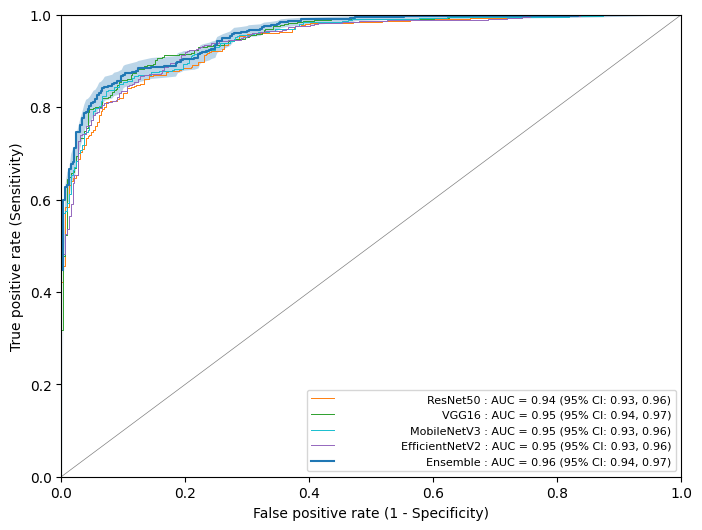

In [11]:
COLOR = {
    'ResNet50'          : 'tab:orange',
    'VGG16'             : 'tab:green',
    'MobileNetV3'       : 'tab:cyan',
    'EfficientNetV2'    : 'tab:purple',
    'Ensemble'          : 'tab:blue',
    'Ensemble_max'      : 'tab:blue',
}

_, ax = plt.subplots(figsize=((8, 6)))
for arch in ['ResNet50', 'VGG16', 'MobileNetV3', 'EfficientNetV2']:
    ax = plot_roc(y_test, y_pred[arch], lw_main=0.7, label_main=arch, col_main=COLOR[arch], plot_rand=False, plot_youden=False, ax=ax)

arch = 'Ensemble'
ax = plot_roc(y_test, y_pred[arch], lw_main=1.5, label_main=arch, col_main=COLOR[arch], plot_conf=True, plot_rand=True, plot_youden=False, ax=ax)

leg = ax.get_legend()
hp = leg._legend_box.get_children()[1]
for vp in hp.get_children():
    for row in vp.get_children():
        row.set_width(360)  # need to adapt this manually
        row.mode= "expand"
        row.align="right"

plt.savefig('241031_ROC_Curve.svg', format='svg')
plt.show()


### **2. Youden J Statistics**

In [12]:
def Proba_ConfidenceInterval(n, n_total, alpha=0.05):
    # Significance Level
    alpha = 0.05
    z_alpha_2 = stats.norm.ppf(1 - alpha / 2.)

    # Probability
    p = n / n_total
    SE = np.sqrt(p * (1 - p) / n_total)
    return [p, p - z_alpha_2 * SE, p + z_alpha_2 * SE]

def summarize(y_test, y_pred, alpha=0.05):
    conf = confusion_matrix(y_test, y_pred, labels=[1, 0])
    TP, FN = conf[0][0], conf[0][1]
    FP, TN = conf[1][0], conf[1][1]

    result = {
        'accuracy': (Proba_ConfidenceInterval(TP + TN, TP + FP + TN + FN, alpha=alpha), TP + TN, TP + FP + TN + FN),
        'sensitivity': (Proba_ConfidenceInterval(TP, TP + FN, alpha=alpha), TP, TP + FN),
        'specificity': (Proba_ConfidenceInterval(TN, FP + TN, alpha=alpha), TN, FP + TN),
        'PPV': (Proba_ConfidenceInterval(TP, TP + FP, alpha=alpha), TP, TP + FP),
        'NPV': (Proba_ConfidenceInterval(TN, TN + FN, alpha=alpha), TN, TN + FN),
    }

    #p = result['PPV']
    #r = result['sensitivity']
    #result['f1-score'] = [2 * p_ * r_ / (p_ + r_) for p_, r_ in zip(p, r)]
    return result, TP, FN, FP, TN

In [13]:
for arch in ['ResNet50', 'VGG16', 'MobileNetV3', 'EfficientNetV2', 'Ensemble']:
    print(f'Performance of [{arch}] ...')
    
    #_, _, thres = YoudenJ(y_test, y_pred[arch])
    thres = 0.5
    y_pred_bin = np.int16(y_pred[arch] > thres)

    result, tp, fn, fp, tn = summarize(y_test, y_pred_bin)
    print(f'TP : {tp} / FN : {fn}')
    print(f'FP : {fp} / TN : {tn}')
    for key in result.keys():
        print(f'{key:12s}: {100*result[key][0][0]:.1f} ({result[key][1]}/{result[key][2]}) [{100*result[key][0][1]:.1f}, {100*result[key][0][2]:.1f}]')
    
    print()

Performance of [ResNet50] ...
TP : 385 / FN : 49
FP : 69 / TN : 262
accuracy    : 84.6 (647/765) [82.0, 87.1]
sensitivity : 88.7 (385/434) [85.7, 91.7]
specificity : 79.2 (262/331) [74.8, 83.5]
PPV         : 84.8 (385/454) [81.5, 88.1]
NPV         : 84.2 (262/311) [80.2, 88.3]

Performance of [VGG16] ...
TP : 393 / FN : 41
FP : 52 / TN : 279
accuracy    : 87.8 (672/765) [85.5, 90.2]
sensitivity : 90.6 (393/434) [87.8, 93.3]
specificity : 84.3 (279/331) [80.4, 88.2]
PPV         : 88.3 (393/445) [85.3, 91.3]
NPV         : 87.2 (279/320) [83.5, 90.8]

Performance of [MobileNetV3] ...
TP : 377 / FN : 57
FP : 45 / TN : 286
accuracy    : 86.7 (663/765) [84.3, 89.1]
sensitivity : 86.9 (377/434) [83.7, 90.0]
specificity : 86.4 (286/331) [82.7, 90.1]
PPV         : 89.3 (377/422) [86.4, 92.3]
NPV         : 83.4 (286/343) [79.4, 87.3]

Performance of [EfficientNetV2] ...
TP : 376 / FN : 58
FP : 43 / TN : 288
accuracy    : 86.8 (664/765) [84.4, 89.2]
sensitivity : 86.6 (376/434) [83.4, 89.8]
speci

### **3. Confusion Matrix**

[[384  50]
 [ 46 285]]


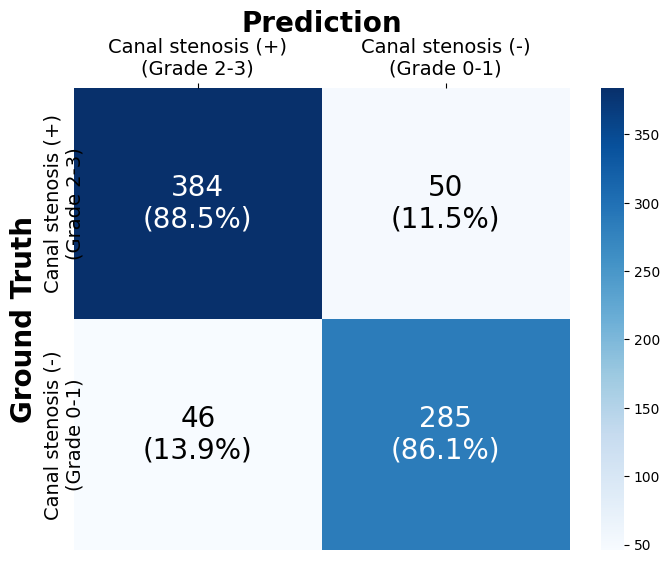

In [14]:
# Confusion Matrix
def PlotConfusionMatrix(y_test, y_pred, save_format='svg'):
    conf = confusion_matrix(y_test, y_pred, labels=[1, 0])
    print(conf)

    tick_labels = ['Canal stenosis (+)\n(Grade 2-3)', 'Canal stenosis (-)\n(Grade 0-1)']
    plt.figure(figsize=(8, 6)); fontsize=20
    ax = sns.heatmap(conf, annot=False, fmt='d', cmap='Blues', annot_kws={'size':16},
                    xticklabels=tick_labels, yticklabels=tick_labels)

    for i in range(2):
        for j in range(2):
            if i == j: color = 'white'
            else: color = 'black'

            text = f'{conf[i][j]}\n({conf[i][j]/sum(conf[i]) * 100 :.1f}%)'
            ax.text(j + 0.5, i + 0.5, text,
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=fontsize, color=color)
            
    ax.set_xlabel('Prediction', fontsize=fontsize, weight='bold')
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

    ax.set_ylabel('Ground Truth', fontsize=fontsize, weight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, ha='center', va='center')

    plt.savefig(f'241031_confusion_matrix.{save_format}', format=save_format)
    plt.show()


#_, _, thres = YoudenJ(y_test, y_pred['Ensemble_max'])
thres = 0.5
y_pred_bin = np.int16(y_pred['Ensemble'] > thres)
PlotConfusionMatrix(y_test, y_pred_bin, save_format='svg')

# **Demographics Statistics**

### **1. Load Labels & Demographics**

In [15]:
# Load Labels
LABEL_FILENAME = 'dataset/ALL/Labels_Final.csv'
df = pd.read_csv(LABEL_FILENAME)

# Preprocess
df['patient_id'] = df['patient_id'].map(lambda x: f'{x:08d}')
df['sex'] = df['sex'].map(lambda x: {'M':1, 'F':0}[x])
df = df[['patient_id', 'sex', 'age', 'label']].set_index('patient_id')

# Train Test Split
df_tval = df.loc[patient_id_tval, :]
df_test = df.loc[patient_id_test, :]

### **2. Train-Validation vs Test**

In [16]:
# Age : Independent T-Test
age_tval = df.loc[patient_id_tval, 'age']
age_test = df.loc[patient_id_test, 'age']
result = ttest_ind(age_tval, age_test)

print(f'===== T-Test Results (Age) =====')
print(f'Mean+/-STD | {age_tval.mean():.2f}+/-{age_tval.std():.2f} vs {age_test.mean():.2f}+/-{age_test.std():.2f}')
print(f'Statistic  | {result.statistic:.5f}')
print(f'P-value    | {result.pvalue:.5f}')
print()

# Sex : Chi2 Contingency Test
sex_tval = df.loc[patient_id_tval, 'sex']
sex_test = df.loc[patient_id_test, 'sex']

freq_obs = [
    [sex_tval.value_counts()[1], sex_tval.value_counts()[0]],
    [sex_test.value_counts()[1], sex_test.value_counts()[0]]
]
result = chi2_contingency(freq_obs)

print(f'===== Chi Square Test Results (Sex) =====')
print(freq_obs)
print(f'Statistic  | {result.statistic:.5f}')
print(f'P-value    | {result.pvalue:.5f}')
print()

# Label : Chi2 Contingency Test
label_tval = df.loc[patient_id_tval, 'label']
label_test = df.loc[patient_id_test, 'label']

freq_obs = [
    [label_tval.value_counts()[0], label_tval.value_counts()[1]],
    [label_test.value_counts()[0], label_test.value_counts()[1]]
]
result = chi2_contingency(freq_obs)

print(f'===== Chi Square Test Results (Label) =====')
print(freq_obs)
print(f'Statistic  | {result.statistic:.5f}')
print(f'P-value    | {result.pvalue:.5f}')
print()

===== T-Test Results (Age) =====
Mean+/-STD | 56.03+/-14.25 vs 56.47+/-14.43
Statistic  | -0.80283
P-value    | 0.42210

===== Chi Square Test Results (Sex) =====
[[3480, 3400], [386, 379]]
Statistic  | 0.00072
P-value    | 0.97854

===== Chi Square Test Results (Label) =====
[[2800, 4080], [331, 434]]
Statistic  | 1.77604
P-value    | 0.18264



### **3. Label = 0 vs Label = 1**

In [17]:
# Age : Independent T-Test
age_0 = df[df['label'] == 0].loc[:, 'age']
age_1 = df[df['label'] == 1].loc[:, 'age']
result = ttest_ind(age_0, age_1)

print(f'===== T-Test Results (Age) =====')
print(f'Mean+/-STD | {age_0.mean():.2f}+/-{age_0.std():.2f} vs {age_1.mean():.2f}+/-{age_1.std():.2f}')
print(f'Statistic  | {result.statistic:.5f}')
print(f'P-value    | {result.pvalue:.5f}')
print()

# Sex : Chi2 Contingency Test
sex_0 = df[df['label'] == 0].loc[:, 'sex']
sex_1 = df[df['label'] == 1].loc[:, 'sex']

freq_obs = [
    [sex_0.value_counts()[1], sex_0.value_counts()[0]],
    [sex_1.value_counts()[1], sex_1.value_counts()[0]]
]
result = chi2_contingency(freq_obs)

print(f'===== Chi Square Test Results (Sex) =====')
print(freq_obs)
print(f'Statistic  | {result.statistic:.5f}')
print(f'P-value    | {result.pvalue:.5f}')
print()

===== T-Test Results (Age) =====
Mean+/-STD | 50.58+/-14.66 vs 59.88+/-12.65
Statistic  | -29.59439
P-value    | 0.00000

===== Chi Square Test Results (Sex) =====
[[1274, 1857], [2592, 1922]]
Statistic  | 206.37017
P-value    | 0.00000



### **4. Multivariate Logistic Regression (Test Set)**

In [18]:
df_test['proba'] = y_pred['Ensemble'] * 100
df_test

,sex,age,label,proba
patient_id,,,,
40004086,0,66,0,21.099358
40513650,1,45,0,25.404749
34931703,0,63,0,62.293297
49674026,0,68,0,25.912708
37548186,0,64,0,7.366730
...,...,...,...,...
36081394,1,63,0,26.419731
48487382,1,55,0,50.309002
15468211,1,42,1,95.647575


##### **Study #1 : Proba, Age, Sex**

In [19]:
INPUT_FEATURES = ['proba', 'age', 'sex']
OUTPUT_FEATURE = ['label']
X, y = df_test[INPUT_FEATURES], df_test[OUTPUT_FEATURE]

# Statsmodels is awesome!!
X = sm.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.277640
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                  765
Model:                          Logit   Df Residuals:                      761
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 Nov 2024   Pseudo R-squ.:                  0.5941
Time:                        14:45:19   Log-Likelihood:                -212.39
converged:                       True   LL-Null:                       -523.30
Covariance Type:            nonrobust   LLR p-value:                1.878e-134
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6223      0.579     -6.253      0.000      -4.758      -2.487
proba          0.0790      0.

In [20]:
for feature in INPUT_FEATURES:
    odds_ratio = np.exp(result.params[feature])
    odds_ratio_lower = np.exp(result.conf_int().loc[feature, 0])
    odds_ratio_upper = np.exp(result.conf_int().loc[feature, 1])
    p_value = result.pvalues[feature]

    print(feature)
    print(f'OR (95% CI) : {odds_ratio:.3f} ({odds_ratio_lower:.3f}-{odds_ratio_upper:.3f})')
    print(f'p-value     : {p_value:.6f}')
    print()

proba
OR (95% CI) : 1.082 (1.071-1.094)
p-value     : 0.000000

age
OR (95% CI) : 0.993 (0.974-1.013)
p-value     : 0.487372

sex
OR (95% CI) : 1.318 (0.799-2.177)
p-value     : 0.279730



##### **Study #2 : Proba, Sex**

In [21]:
INPUT_FEATURES = ['proba', 'sex']
OUTPUT_FEATURE = ['label']
X, y = df_test[INPUT_FEATURES], df_test[OUTPUT_FEATURE]

# Statsmodels is awesome!!
X = sm.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.277956
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                  765
Model:                          Logit   Df Residuals:                      762
Method:                           MLE   Df Model:                            2
Date:                Tue, 12 Nov 2024   Pseudo R-squ.:                  0.5937
Time:                        14:45:19   Log-Likelihood:                -212.64
converged:                       True   LL-Null:                       -523.30
Covariance Type:            nonrobust   LLR p-value:                1.200e-135
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9711      0.303    -13.112      0.000      -4.565      -3.377
proba          0.0780      0.

In [22]:
for feature in INPUT_FEATURES:
    odds_ratio = np.exp(result.params[feature])
    odds_ratio_lower = np.exp(result.conf_int().loc[feature, 0])
    odds_ratio_upper = np.exp(result.conf_int().loc[feature, 1])
    p_value = result.pvalues[feature]

    print(feature)
    print(f'OR (95% CI) : {odds_ratio:.3f} ({odds_ratio_lower:.3f}-{odds_ratio_upper:.3f})')
    print(f'p-value     : {p_value:.6f}')
    print()

proba
OR (95% CI) : 1.081 (1.070-1.092)
p-value     : 0.000000

sex
OR (95% CI) : 1.339 (0.813-2.206)
p-value     : 0.252046



##### **Study #3 : Proba only**

In [23]:
INPUT_FEATURES = ['proba']
OUTPUT_FEATURE = ['label']
X, y = df_test[INPUT_FEATURES], df_test[OUTPUT_FEATURE]

# Statsmodels is awesome!!
X = sm.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.278810
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                  765
Model:                          Logit   Df Residuals:                      763
Method:                           MLE   Df Model:                            1
Date:                Tue, 12 Nov 2024   Pseudo R-squ.:                  0.5924
Time:                        14:45:19   Log-Likelihood:                -213.29
converged:                       True   LL-Null:                       -523.30
Covariance Type:            nonrobust   LLR p-value:                7.381e-137
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8680      0.286    -13.542      0.000      -4.428      -3.308
proba          0.0786      0.

In [24]:
for feature in INPUT_FEATURES:
    odds_ratio = np.exp(result.params[feature])
    odds_ratio_lower = np.exp(result.conf_int().loc[feature, 0])
    odds_ratio_upper = np.exp(result.conf_int().loc[feature, 1])
    p_value = result.pvalues[feature]

    print(feature)
    print(f'OR (95% CI) : {odds_ratio:.3f} ({odds_ratio_lower:.3f}-{odds_ratio_upper:.3f})')
    print(f'p-value     : {p_value:.6f}')
    print()

proba
OR (95% CI) : 1.082 (1.071-1.092)
p-value     : 0.000000



# **Grad-CAM**

In [25]:
#1/0

In [26]:
def make_gradcam_heatmap(image, model, conv_layer_name, pred_idx=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_layer_out, preds = grad_model(image)
        
        if pred_idx  is None:
            pred_idx = tf.argmax(preds[0])
        class_channel = preds[:, pred_idx]

    grads = tape.gradient(class_channel, conv_layer_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_layer_out = conv_layer_out[0]
    heatmap = conv_layer_out @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) #/ tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds

In [27]:
def overlap_image_heatmap(image, heatmap, cmap='plasma', alpha=1):
    heatmap = np.abs(heatmap)
    heatmap = heatmap / np.max(heatmap)
    heatmap = np.uint8(heatmap * 255.)
    
    cmap = mpl.colormaps[cmap]
    cmap_colors = cmap(np.arange(256))[:, :3]
    cmap_heatmap = cmap_colors[heatmap]

    image = image / 255.
    image = (image + cmap_heatmap * alpha) / (1 + alpha)
    image = np.minimum(image, 1)
    return image

In [28]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

In [29]:
def save_images(images, labels, figsize=(5, 5), ncols=6, save_filename=''):
    plt.ioff()
    
    def show_image(image, label, figsize=(5, 5), ax=None):
        plt.ioff()
        if ax is None:
            _, ax = plt.subplots(figsize=figsize)

        if image.shape[-1] != 3:
            ax.imshow(image, cmap='gray')
        else:
            ax.imshow(image)

        ax.set_title(f'{label}')
        ax.set_axis_off()

    try: nrows = 1 + (images.shape[0] - 1) // ncols
    except: nrows = 1 + (len(images) - 1) // ncols
    
    figsize_full = (ncols * figsize[0], nrows * figsize[1])
    _, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize_full)

    for i in range(nrows):
        for j in range(ncols):
            idx = i * ncols + j
            image, label = images[idx], labels[idx]
            try: show_image(image, label, figsize=figsize, ax=axs[i][j])
            except: show_image(image, label, figsize=figsize, ax=axs[j])

    save_format = save_filename[-3:]
    plt.savefig(save_filename, format=save_format)

In [31]:
plt.ioff()
for idx, patient_id in tqdm(enumerate(patient_id_test)):
    X_input = X_test[idx, :, :].astype(np.uint8)
    label = df_test.loc[patient_id, 'label']
    proba = df_test.loc[patient_id, 'proba'] / 100.

    image_list = [X_input[:, :, 1], X_input]
    label_list = [f'TEST #{idx} [{patient_id}]', f'Input (Label={label})']

    heatmap_ensemble = None
    out_ensemble = 0
    N_MODELS = 4

    for arch in ['ResNet50', 'VGG16', 'MobileNetV3', 'EfficientNetV2']:
        trial_dir = TRIAL_DIR[arch]
        HPARAMS_ARCH_FILENAME = f'{trial_dir}/hparams_arch.pkl'
        hparams_arch = pickle.load(open(HPARAMS_ARCH_FILENAME, 'rb'))

        FF_LAYER_LIST               = hparams_arch['FF_LAYER_LIST']
        DROPOUT_RATE                = hparams_arch['DROPOUT_RATE']

        # Load Base Model
        if arch == 'ResNet50':
            base_model = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
        elif arch == 'VGG16':
            base_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')
        elif arch == 'EfficientNetV2':
            base_model = keras.applications.efficientnet_v2.EfficientNetV2S(include_top=False, weights='imagenet')
        elif arch == 'MobileNetV3':
            base_model = keras.applications.MobileNetV3Large(include_top=False, weights='imagenet')

        # Add FF Layers
        out = GlobalAveragePooling2D()(base_model.output)
        for n_node in FF_LAYER_LIST:
            out = Dropout(rate=DROPOUT_RATE, name=f'CustomDrop_{n_node}')(out)
            out = Dense(n_node, activation='relu', name=f'CustomFF_{n_node}')(out)
            out = BatchNormalization(name=f'CustomBN_{n_node}')(out)

        # Final Output
        out = Dropout(rate=DROPOUT_RATE, name='CustomDrop_final')(out)
        out = Dense(1, name='CustomFF_final')(out)

        # Define Model
        model = keras.Model(inputs=[base_model.input], outputs=[out])
        conv_layer_name = base_model.layers[-1].name

        # Obtain GradCAM
        N_FOLD = 3
        heatmap, out = None, 0
        for i in range(N_FOLD):
            model.load_weights(f'{trial_dir}/weights_{i}.hdf5')
            heatmap_, out_ = make_gradcam_heatmap(X_input[np.newaxis, ...], model, conv_layer_name)
            
            try: heatmap += heatmap_
            except: heatmap = heatmap_
            
            out += sigmoid(out_[0][0]) / N_FOLD

        # Resize & Add Heatmap
        heatmap = cv2.resize(heatmap, (112, 224))
        try: heatmap_ensemble += heatmap
        except: heatmap_ensemble = heatmap

        out_ensemble += out / N_MODELS
        overlap_image = overlap_image_heatmap(X_input, heatmap, cmap='plasma', alpha=1)

        image_list.append(overlap_image)
        label_list.append(f'{arch} [pred={out:.2f}]')

    overlap_image = overlap_image_heatmap(X_input, heatmap_ensemble, cmap='plasma', alpha=1)

    image_list.append(overlap_image)
    label_list.append(f'Ensemble [pred={out_ensemble:.2f}]')
    save_filename = f'grad_cam_png/test_{idx:03d}_ptid={patient_id}_label={label}_pred={out_ensemble:.2f}.png'
    save_images(image_list, label_list, figsize=(4, 8), ncols=7, save_filename=save_filename)
    #ShowImages(image_list, label_list, figsize=(4, 8), ncols=7)

0it [00:00, ?it/s]

1it [00:04,  4.99s/it]

2it [00:09,  4.85s/it]

3it [00:14,  4.75s/it]

4it [00:19,  4.74s/it]

5it [00:24,  4.82s/it]

6it [00:28,  4.85s/it]

7it [00:33,  4.86s/it]

8it [00:38,  4.80s/it]

9it [00:43,  4.82s/it]

10it [00:48,  4.89s/it]

11it [00:53,  4.85s/it]

12it [00:58,  4.89s/it]

13it [01:03,  4.91s/it]

14it [01:07,  4.83s/it]

15it [01:12,  4.92s/it]

16it [01:17,  4.84s/it]

17it [01:22,  4.93s/it]

18it [01:27,  4.88s/it]

19it [01:32,  4.94s/it]

20it [01:37,  4.90s/it]

21it [01:42,  5.01s/it]

22it [01:47,  4.96s/it]

23it [01:52,  5.08s/it]

24it [01:57,  5.01s/it]

25it [02:02,  4.95s/it]

26it [02:07,  5.07s/it]

27it [02:12,  4.90s/it]

28it [02:17,  4.98s/it]

29it [02:22,  4.90s/it]

30it [02:26,  4.85s/it]

31it [02:32,  5.01s/it]

32it [02:37,  4.96s/it]

33it [02:42,  5.06s/it]

34it [02:47,  4.98s/it]

35it [02:52,  4.93s/it]

36it [02:57,  5.10s/it]

37it [03:02,  5.05s/it]

38it [03:07,  4.97s/it]

39it [03:12,  5.14s/it]

40it [03:17,  5.03s/it]

41it [03:22,  4.95s/it]

42it [03:27,  4.87s/it]

43it [03:32,  5.11s/it]

44it [03:37,  5.05s/it]

45it [03:42,  4.97s/it]

46it [03:48,  5.21s/it]

47it [03:53,  5.12s/it]

48it [03:57,  5.02s/it]

49it [04:02,  4.99s/it]

50it [04:08,  5.22s/it]

51it [04:13,  5.11s/it]

52it [04:18,  5.07s/it]

53it [04:23,  5.01s/it]

54it [04:29,  5.26s/it]

55it [04:33,  5.14s/it]

56it [04:38,  5.04s/it]

57it [04:43,  4.98s/it]

58it [04:49,  5.29s/it]

59it [04:54,  5.18s/it]

60it [04:59,  5.11s/it]

61it [05:04,  5.09s/it]

62it [05:10,  5.39s/it]

63it [05:15,  5.22s/it]

64it [05:20,  5.17s/it]

65it [05:25,  5.11s/it]

66it [05:31,  5.41s/it]

67it [05:36,  5.34s/it]

68it [05:41,  5.28s/it]

69it [05:46,  5.22s/it]

70it [05:51,  5.13s/it]

71it [05:58,  5.45s/it]

72it [06:03,  5.38s/it]

73it [06:08,  5.31s/it]

74it [06:13,  5.24s/it]

75it [06:18,  5.20s/it]

76it [06:25,  5.56s/it]

77it [06:30,  5.46s/it]

78it [06:35,  5.33s/it]

79it [06:40,  5.25s/it]

80it [06:45,  5.21s/it]

81it [06:50,  5.15s/it]

82it [06:57,  5.63s/it]

83it [07:02,  5.50s/it]

84it [07:07,  5.38s/it]

85it [07:12,  5.29s/it]

86it [07:17,  5.25s/it]

87it [07:24,  5.66s/it]

88it [07:29,  5.55s/it]

89it [07:34,  5.47s/it]

90it [07:40,  5.38s/it]

91it [07:45,  5.32s/it]

92it [07:50,  5.30s/it]

93it [07:57,  5.75s/it]

94it [08:02,  5.61s/it]

95it [08:07,  5.48s/it]

96it [08:13,  5.42s/it]

97it [08:18,  5.35s/it]

98it [08:23,  5.31s/it]

99it [08:28,  5.27s/it]

100it [08:35,  5.79s/it]

101it [08:41,  5.68s/it]

102it [08:46,  5.58s/it]

103it [08:51,  5.45s/it]

104it [08:56,  5.35s/it]

105it [09:01,  5.28s/it]

106it [09:08,  5.82s/it]

107it [09:14,  5.62s/it]

108it [09:19,  5.52s/it]

109it [09:24,  5.45s/it]

110it [09:29,  5.40s/it]

111it [09:35,  5.36s/it]

112it [09:40,  5.35s/it]

113it [09:47,  5.92s/it]

114it [09:53,  5.79s/it]

115it [09:58,  5.69s/it]

116it [10:04,  5.60s/it]

117it [10:09,  5.55s/it]

118it [10:14,  5.49s/it]

119it [10:20,  5.42s/it]

120it [10:25,  5.35s/it]

121it [10:32,  5.96s/it]

122it [10:38,  5.78s/it]

123it [10:43,  5.74s/it]

124it [10:49,  5.62s/it]

125it [10:54,  5.55s/it]

126it [10:59,  5.52s/it]

127it [11:05,  5.46s/it]

128it [11:10,  5.46s/it]

129it [11:18,  6.13s/it]

130it [11:23,  6.00s/it]

131it [11:29,  5.87s/it]

132it [11:35,  5.74s/it]

133it [11:40,  5.67s/it]

134it [11:46,  5.64s/it]

135it [11:51,  5.58s/it]

136it [11:56,  5.54s/it]

137it [12:04,  6.24s/it]

138it [12:10,  6.02s/it]

139it [12:15,  5.87s/it]

140it [12:21,  5.76s/it]

141it [12:27,  5.74s/it]

142it [12:32,  5.65s/it]

143it [12:37,  5.59s/it]

144it [12:43,  5.55s/it]

145it [12:48,  5.55s/it]

146it [12:56,  6.28s/it]

147it [13:02,  6.07s/it]

148it [13:08,  5.92s/it]

149it [13:13,  5.78s/it]

150it [13:19,  5.72s/it]

151it [13:24,  5.61s/it]

152it [13:30,  5.58s/it]

153it [13:35,  5.59s/it]

154it [13:41,  5.57s/it]

155it [13:49,  6.34s/it]

156it [13:54,  6.14s/it]

157it [14:00,  5.93s/it]

158it [14:05,  5.83s/it]

159it [14:11,  5.82s/it]

160it [14:17,  5.77s/it]

161it [14:23,  5.72s/it]

162it [14:28,  5.69s/it]

163it [14:34,  5.64s/it]

164it [14:39,  5.64s/it]

165it [14:48,  6.51s/it]

166it [14:54,  6.28s/it]

167it [14:59,  6.16s/it]

168it [15:05,  5.96s/it]

169it [15:11,  5.87s/it]

170it [15:16,  5.82s/it]

171it [15:22,  5.79s/it]

172it [15:28,  5.75s/it]

173it [15:33,  5.73s/it]

174it [15:39,  5.74s/it]

175it [15:48,  6.68s/it]

176it [15:54,  6.46s/it]

177it [16:00,  6.26s/it]

178it [16:06,  6.13s/it]

179it [16:11,  6.05s/it]

180it [16:17,  6.01s/it]

181it [16:23,  5.93s/it]

182it [16:29,  5.89s/it]

183it [16:35,  5.83s/it]

184it [16:41,  5.85s/it]

185it [16:46,  5.82s/it]

186it [16:52,  5.84s/it]

187it [17:01,  6.84s/it]

188it [17:07,  6.53s/it]

189it [17:13,  6.29s/it]

190it [17:19,  6.19s/it]

191it [17:25,  6.12s/it]

192it [17:31,  6.05s/it]

193it [17:37,  6.00s/it]

194it [17:42,  5.93s/it]

195it [17:48,  5.93s/it]

196it [17:54,  5.89s/it]

197it [18:00,  5.80s/it]

198it [18:09,  6.86s/it]

199it [18:15,  6.62s/it]

200it [18:21,  6.40s/it]

201it [18:27,  6.26s/it]

202it [18:33,  6.13s/it]

203it [18:39,  6.07s/it]

204it [18:45,  6.04s/it]

205it [18:51,  6.01s/it]

206it [18:56,  5.99s/it]

207it [19:02,  5.97s/it]

208it [19:08,  5.97s/it]

209it [19:14,  5.92s/it]

210it [19:20,  5.93s/it]

211it [19:30,  7.11s/it]

212it [19:36,  6.79s/it]

213it [19:42,  6.53s/it]

214it [19:48,  6.36s/it]

215it [19:54,  6.26s/it]

216it [20:00,  6.25s/it]

217it [20:06,  6.19s/it]

218it [20:12,  6.11s/it]

219it [20:18,  6.08s/it]

220it [20:24,  6.04s/it]

221it [20:30,  6.06s/it]

222it [20:36,  6.04s/it]

223it [20:42,  6.04s/it]

224it [20:52,  7.24s/it]

225it [20:58,  6.92s/it]

226it [21:05,  6.72s/it]

227it [21:11,  6.54s/it]

228it [21:17,  6.41s/it]

229it [21:23,  6.34s/it]

230it [21:29,  6.27s/it]

231it [21:36,  6.29s/it]

232it [21:42,  6.21s/it]

233it [21:48,  6.14s/it]

234it [21:53,  6.07s/it]

235it [22:00,  6.09s/it]

236it [22:06,  6.10s/it]

237it [22:16,  7.34s/it]

238it [22:22,  7.03s/it]

239it [22:28,  6.78s/it]

240it [22:35,  6.64s/it]

241it [22:41,  6.52s/it]

242it [22:47,  6.43s/it]

243it [22:53,  6.35s/it]

244it [23:00,  6.35s/it]

245it [23:06,  6.31s/it]

246it [23:12,  6.29s/it]

247it [23:18,  6.26s/it]

248it [23:25,  6.28s/it]

249it [23:31,  6.29s/it]

250it [23:37,  6.24s/it]

251it [23:43,  6.21s/it]

252it [23:54,  7.55s/it]

253it [24:00,  7.22s/it]

254it [24:07,  6.94s/it]

255it [24:13,  6.75s/it]

256it [24:19,  6.63s/it]

257it [24:26,  6.60s/it]

258it [24:32,  6.56s/it]

259it [24:39,  6.49s/it]

260it [24:45,  6.42s/it]

261it [24:51,  6.40s/it]

262it [24:58,  6.41s/it]

263it [25:04,  6.40s/it]

264it [25:10,  6.39s/it]

265it [25:17,  6.36s/it]

266it [25:23,  6.36s/it]

267it [25:34,  7.74s/it]

268it [25:41,  7.40s/it]

269it [25:47,  7.15s/it]

270it [25:54,  6.97s/it]

271it [26:00,  6.83s/it]

272it [26:07,  6.73s/it]

273it [26:13,  6.66s/it]

274it [26:20,  6.63s/it]

275it [26:26,  6.56s/it]

276it [26:33,  6.52s/it]

277it [26:39,  6.53s/it]

278it [26:46,  6.56s/it]

279it [26:52,  6.54s/it]

280it [26:59,  6.51s/it]

281it [27:05,  6.49s/it]

282it [27:12,  6.47s/it]

283it [27:18,  6.47s/it]

284it [27:30,  8.02s/it]

285it [27:36,  7.60s/it]

286it [27:43,  7.33s/it]

287it [27:50,  7.15s/it]

288it [27:56,  7.00s/it]

289it [28:03,  6.89s/it]

290it [28:10,  6.85s/it]

291it [28:16,  6.78s/it]

292it [28:23,  6.73s/it]

293it [28:30,  6.69s/it]

294it [28:36,  6.66s/it]

295it [28:43,  6.65s/it]

296it [28:50,  6.65s/it]

297it [28:56,  6.69s/it]

298it [29:03,  6.62s/it]

299it [29:09,  6.56s/it]

300it [29:16,  6.56s/it]

301it [29:28,  8.20s/it]

302it [29:35,  7.82s/it]

303it [29:41,  7.50s/it]

304it [29:48,  7.28s/it]

305it [29:55,  7.14s/it]

306it [30:02,  7.01s/it]

307it [30:09,  6.96s/it]

308it [30:15,  6.90s/it]

309it [30:22,  6.86s/it]

310it [30:29,  6.84s/it]

311it [30:36,  6.84s/it]

312it [30:43,  6.83s/it]

313it [30:49,  6.80s/it]

314it [30:56,  6.77s/it]

315it [31:03,  6.72s/it]

316it [31:09,  6.75s/it]

317it [31:16,  6.71s/it]

318it [31:23,  6.73s/it]

319it [31:35,  8.47s/it]

320it [31:42,  8.02s/it]

321it [31:49,  7.70s/it]

322it [31:56,  7.46s/it]

323it [32:03,  7.28s/it]

324it [32:10,  7.12s/it]

325it [32:17,  7.03s/it]

326it [32:23,  6.97s/it]

327it [32:30,  6.93s/it]

328it [32:37,  6.89s/it]

329it [32:44,  6.84s/it]

330it [32:51,  6.87s/it]

331it [32:58,  6.92s/it]

332it [33:05,  6.93s/it]

333it [33:12,  6.93s/it]

334it [33:19,  6.93s/it]

335it [33:25,  6.90s/it]

336it [33:32,  6.93s/it]

337it [33:39,  6.96s/it]

338it [33:52,  8.74s/it]

339it [34:00,  8.34s/it]

340it [34:07,  8.00s/it]

341it [34:14,  7.74s/it]

342it [34:21,  7.57s/it]

343it [34:28,  7.44s/it]

344it [34:35,  7.27s/it]

345it [34:42,  7.21s/it]

346it [34:49,  7.16s/it]

347it [34:56,  7.12s/it]

348it [35:03,  7.07s/it]

349it [35:10,  7.08s/it]

350it [35:18,  7.12s/it]

351it [35:25,  7.12s/it]

352it [35:32,  7.12s/it]

353it [35:39,  7.12s/it]

354it [35:46,  7.10s/it]

355it [35:53,  7.10s/it]

356it [36:00,  7.12s/it]

357it [36:07,  7.11s/it]

358it [36:21,  9.01s/it]

359it [36:28,  8.55s/it]

360it [36:36,  8.17s/it]

361it [36:43,  7.92s/it]

362it [36:50,  7.77s/it]

363it [36:58,  7.63s/it]

364it [37:05,  7.52s/it]

365it [37:12,  7.45s/it]

366it [37:19,  7.37s/it]

367it [37:27,  7.36s/it]

368it [37:34,  7.38s/it]

369it [37:42,  7.38s/it]

370it [37:49,  7.39s/it]

371it [37:56,  7.41s/it]

372it [38:04,  7.35s/it]

373it [38:11,  7.42s/it]

374it [38:19,  7.43s/it]

375it [38:26,  7.37s/it]

376it [38:33,  7.40s/it]

377it [38:41,  7.39s/it]

378it [38:48,  7.39s/it]

379it [38:56,  7.42s/it]

380it [39:10,  9.49s/it]

381it [39:18,  8.99s/it]

382it [39:25,  8.57s/it]

383it [39:33,  8.33s/it]

384it [39:41,  8.10s/it]

385it [39:48,  7.95s/it]

386it [39:56,  7.84s/it]

387it [40:03,  7.75s/it]

388it [40:11,  7.75s/it]

389it [40:19,  7.73s/it]

390it [40:26,  7.68s/it]

391it [40:34,  7.67s/it]

392it [40:42,  7.65s/it]

393it [40:49,  7.63s/it]

394it [40:57,  7.61s/it]

395it [41:04,  7.55s/it]

396it [41:12,  7.56s/it]

397it [41:19,  7.51s/it]

398it [41:27,  7.52s/it]

399it [41:34,  7.56s/it]

400it [41:42,  7.58s/it]

401it [41:50,  7.59s/it]

402it [42:04,  9.72s/it]

403it [42:12,  9.22s/it]

404it [42:20,  8.83s/it]

405it [42:28,  8.55s/it]

406it [42:36,  8.32s/it]

407it [42:44,  8.18s/it]

408it [42:52,  8.02s/it]

409it [42:59,  7.93s/it]

410it [43:07,  7.91s/it]

411it [43:15,  7.88s/it]

412it [43:23,  7.84s/it]

413it [43:31,  7.85s/it]

414it [43:38,  7.79s/it]

415it [43:46,  7.75s/it]

416it [43:54,  7.73s/it]

417it [44:01,  7.72s/it]

418it [44:09,  7.75s/it]

419it [44:17,  7.75s/it]

420it [44:24,  7.68s/it]

421it [44:32,  7.73s/it]

422it [44:40,  7.68s/it]

423it [44:48,  7.74s/it]

424it [44:55,  7.76s/it]

425it [45:03,  7.80s/it]

426it [45:19, 10.08s/it]

427it [45:27,  9.51s/it]

428it [45:35,  9.08s/it]

429it [45:43,  8.75s/it]

430it [45:51,  8.52s/it]

431it [45:59,  8.37s/it]

432it [46:07,  8.30s/it]

433it [46:15,  8.20s/it]

434it [46:23,  8.14s/it]

435it [46:31,  8.08s/it]

436it [46:39,  8.03s/it]

437it [46:47,  8.06s/it]

438it [46:55,  7.99s/it]

439it [47:03,  8.05s/it]

440it [47:11,  8.03s/it]

441it [47:19,  8.02s/it]

442it [47:27,  7.99s/it]

443it [47:35,  8.00s/it]

444it [47:43,  7.97s/it]

445it [47:51,  8.00s/it]

446it [47:59,  8.04s/it]

447it [48:07,  8.02s/it]

448it [48:15,  8.02s/it]

449it [48:23,  8.03s/it]

450it [48:31,  8.12s/it]

451it [48:47, 10.49s/it]

452it [48:56,  9.89s/it]

453it [49:05,  9.49s/it]

454it [49:13,  9.17s/it]

455it [49:21,  8.94s/it]

456it [49:30,  8.77s/it]

457it [49:38,  8.64s/it]

458it [49:47,  8.62s/it]

459it [49:55,  8.55s/it]

460it [50:03,  8.45s/it]

461it [50:12,  8.42s/it]

462it [50:20,  8.34s/it]

463it [50:28,  8.36s/it]

464it [50:37,  8.39s/it]

465it [50:45,  8.40s/it]

466it [50:53,  8.42s/it]

467it [51:02,  8.40s/it]

468it [51:10,  8.40s/it]

469it [51:18,  8.35s/it]

470it [51:27,  8.37s/it]

471it [51:35,  8.35s/it]

472it [51:44,  8.39s/it]

473it [51:52,  8.42s/it]

474it [52:01,  8.42s/it]

475it [52:09,  8.47s/it]

476it [52:18,  8.44s/it]

477it [52:26,  8.42s/it]

478it [52:43, 10.98s/it]

479it [52:51, 10.28s/it]

480it [53:00,  9.84s/it]

481it [53:09,  9.52s/it]

482it [53:18,  9.30s/it]

483it [53:26,  9.10s/it]

484it [53:35,  8.99s/it]

485it [53:44,  8.93s/it]

486it [53:53,  8.83s/it]

487it [54:01,  8.78s/it]

488it [54:10,  8.75s/it]

489it [54:18,  8.64s/it]

490it [54:27,  8.64s/it]

491it [54:36,  8.62s/it]

492it [54:44,  8.67s/it]

493it [54:53,  8.62s/it]

494it [55:01,  8.60s/it]

495it [55:10,  8.58s/it]

496it [55:18,  8.55s/it]

497it [55:27,  8.58s/it]

498it [55:36,  8.65s/it]

499it [55:45,  8.72s/it]

500it [55:53,  8.71s/it]

501it [56:02,  8.75s/it]

502it [56:11,  8.75s/it]

503it [56:20,  8.78s/it]

504it [56:29,  8.80s/it]

505it [56:38,  8.85s/it]

506it [56:56, 11.54s/it]

507it [57:05, 10.87s/it]

508it [57:14, 10.35s/it]

509it [57:23,  9.97s/it]

510it [57:32,  9.72s/it]

511it [57:41,  9.53s/it]

512it [57:51,  9.44s/it]

513it [58:00,  9.36s/it]

514it [58:09,  9.26s/it]

515it [58:18,  9.19s/it]

516it [58:27,  9.09s/it]

517it [58:36,  9.04s/it]

518it [58:44,  9.02s/it]

519it [58:53,  9.00s/it]

520it [59:03,  9.02s/it]

521it [59:12,  9.01s/it]

522it [59:20,  9.00s/it]

523it [59:29,  8.98s/it]

524it [59:38,  8.98s/it]

525it [59:48,  9.05s/it]

526it [59:57,  9.09s/it]

527it [1:00:06,  9.06s/it]

528it [1:00:15,  9.05s/it]

529it [1:00:24,  9.10s/it]

530it [1:00:33,  9.12s/it]

531it [1:00:42,  9.13s/it]

532it [1:00:52,  9.17s/it]

533it [1:01:01,  9.19s/it]

534it [1:01:10,  9.21s/it]

535it [1:01:19,  9.12s/it]

536it [1:01:37, 11.90s/it]

537it [1:01:47, 11.20s/it]

538it [1:01:57, 10.76s/it]

539it [1:02:06, 10.40s/it]

540it [1:02:16, 10.15s/it]

541it [1:02:25,  9.93s/it]

542it [1:02:34,  9.73s/it]

543it [1:02:44,  9.56s/it]

544it [1:02:53,  9.53s/it]

545it [1:03:02,  9.46s/it]

546it [1:03:12,  9.42s/it]

547it [1:03:21,  9.37s/it]

548it [1:03:30,  9.41s/it]

549it [1:03:40,  9.44s/it]

550it [1:03:49,  9.44s/it]

551it [1:03:59,  9.42s/it]

552it [1:04:08,  9.43s/it]

553it [1:04:18,  9.38s/it]

554it [1:04:27,  9.41s/it]

555it [1:04:36,  9.41s/it]

556it [1:04:46,  9.43s/it]

557it [1:04:55,  9.46s/it]

558it [1:05:05,  9.47s/it]

559it [1:05:14,  9.46s/it]

560it [1:05:24,  9.51s/it]

561it [1:05:33,  9.51s/it]

562it [1:05:43,  9.50s/it]

563it [1:05:53,  9.56s/it]

564it [1:06:02,  9.45s/it]

565it [1:06:11,  9.47s/it]

566it [1:06:21,  9.54s/it]

567it [1:06:31,  9.60s/it]

568it [1:06:51, 12.68s/it]

569it [1:07:01, 11.86s/it]

570it [1:07:11, 11.32s/it]

571it [1:07:21, 10.89s/it]

572it [1:07:31, 10.61s/it]

573it [1:07:40, 10.37s/it]

574it [1:07:50, 10.21s/it]

575it [1:08:00, 10.15s/it]

576it [1:08:10, 10.01s/it]

577it [1:08:20,  9.90s/it]

578it [1:08:29,  9.88s/it]

579it [1:08:39,  9.86s/it]

580it [1:08:49,  9.85s/it]

581it [1:08:59,  9.88s/it]

582it [1:09:09,  9.87s/it]

583it [1:09:18,  9.81s/it]

584it [1:09:28,  9.82s/it]

585it [1:09:38,  9.84s/it]

586it [1:09:48,  9.86s/it]

587it [1:09:58,  9.86s/it]

588it [1:10:08,  9.88s/it]

589it [1:10:18,  9.83s/it]

590it [1:10:27,  9.82s/it]

591it [1:10:38,  9.91s/it]

592it [1:10:47,  9.93s/it]

593it [1:10:57,  9.94s/it]

594it [1:11:07,  9.96s/it]

595it [1:11:17,  9.92s/it]

596it [1:11:27,  9.91s/it]

597it [1:11:37,  9.87s/it]

598it [1:11:47,  9.88s/it]

599it [1:11:57,  9.89s/it]

600it [1:12:07,  9.96s/it]

601it [1:12:27, 13.15s/it]

602it [1:12:38, 12.29s/it]

603it [1:12:48, 11.75s/it]

604it [1:12:59, 11.32s/it]

605it [1:13:09, 11.05s/it]

606it [1:13:19, 10.84s/it]

607it [1:13:30, 10.71s/it]

608it [1:13:40, 10.62s/it]

609it [1:13:51, 10.54s/it]

610it [1:14:01, 10.48s/it]

611it [1:14:11, 10.43s/it]

612it [1:14:21, 10.40s/it]

613it [1:14:31, 10.28s/it]

614it [1:14:42, 10.23s/it]

615it [1:14:52, 10.21s/it]

616it [1:15:02, 10.17s/it]

617it [1:15:12, 10.18s/it]

618it [1:15:22, 10.19s/it]

619it [1:15:33, 10.24s/it]

620it [1:15:43, 10.24s/it]

621it [1:15:53, 10.28s/it]

622it [1:16:04, 10.31s/it]

623it [1:16:14, 10.26s/it]

624it [1:16:24, 10.26s/it]

625it [1:16:34, 10.28s/it]

626it [1:16:45, 10.28s/it]

627it [1:16:55, 10.25s/it]

628it [1:17:05, 10.25s/it]

629it [1:17:15, 10.29s/it]

630it [1:17:26, 10.34s/it]

631it [1:17:36, 10.35s/it]

632it [1:17:46, 10.26s/it]

633it [1:17:57, 10.28s/it]

634it [1:18:07, 10.27s/it]

635it [1:18:17, 10.34s/it]

636it [1:18:39, 13.78s/it]

637it [1:18:50, 12.96s/it]

638it [1:19:01, 12.31s/it]

639it [1:19:12, 11.85s/it]

640it [1:19:22, 11.47s/it]

641it [1:19:33, 11.30s/it]

642it [1:19:44, 11.09s/it]

643it [1:19:55, 11.04s/it]

644it [1:20:06, 10.98s/it]

645it [1:20:16, 10.94s/it]

646it [1:20:27, 10.80s/it]

647it [1:20:38, 10.80s/it]

648it [1:20:49, 10.85s/it]

649it [1:21:00, 10.87s/it]

650it [1:21:10, 10.86s/it]

651it [1:21:21, 10.82s/it]

652it [1:21:32, 10.82s/it]

653it [1:21:43, 10.80s/it]

654it [1:21:54, 10.82s/it]

655it [1:22:05, 10.84s/it]

656it [1:22:15, 10.86s/it]

657it [1:22:26, 10.82s/it]

658it [1:22:37, 10.85s/it]

659it [1:22:48, 10.86s/it]

660it [1:22:59, 10.84s/it]

661it [1:23:09, 10.76s/it]

662it [1:23:20, 10.77s/it]

663it [1:23:31, 10.81s/it]

664it [1:23:42, 10.82s/it]

665it [1:23:53, 10.81s/it]

666it [1:24:03, 10.76s/it]

667it [1:24:14, 10.78s/it]

668it [1:24:25, 10.87s/it]

669it [1:24:36, 10.77s/it]

670it [1:24:47, 10.76s/it]

671it [1:24:57, 10.75s/it]

672it [1:25:08, 10.79s/it]

673it [1:25:31, 14.45s/it]

674it [1:25:42, 13.53s/it]

675it [1:25:54, 12.92s/it]

676it [1:26:05, 12.44s/it]

677it [1:26:17, 12.09s/it]

678it [1:26:28, 11.88s/it]

679it [1:26:39, 11.65s/it]

680it [1:26:50, 11.46s/it]

681it [1:27:01, 11.36s/it]

682it [1:27:12, 11.31s/it]

683it [1:27:24, 11.25s/it]

684it [1:27:35, 11.30s/it]

685it [1:27:46, 11.30s/it]

686it [1:27:58, 11.36s/it]

687it [1:28:09, 11.31s/it]

688it [1:28:20, 11.34s/it]

689it [1:28:31, 11.29s/it]

690it [1:28:43, 11.25s/it]

691it [1:28:54, 11.17s/it]

692it [1:29:05, 11.21s/it]

693it [1:29:16, 11.26s/it]

694it [1:29:28, 11.33s/it]

695it [1:29:39, 11.32s/it]

696it [1:29:51, 11.40s/it]

697it [1:30:02, 11.33s/it]

698it [1:30:13, 11.38s/it]

699it [1:30:25, 11.40s/it]

700it [1:30:36, 11.36s/it]

701it [1:30:47, 11.30s/it]

702it [1:30:59, 11.32s/it]

703it [1:31:10, 11.42s/it]

704it [1:31:22, 11.41s/it]

705it [1:31:33, 11.42s/it]

706it [1:31:45, 11.45s/it]

707it [1:31:56, 11.40s/it]

708it [1:32:07, 11.44s/it]

709it [1:32:19, 11.47s/it]

710it [1:32:31, 11.49s/it]

711it [1:32:42, 11.49s/it]

712it [1:32:54, 11.50s/it]

713it [1:33:18, 15.46s/it]

714it [1:33:30, 14.47s/it]

715it [1:33:42, 13.74s/it]

716it [1:33:55, 13.27s/it]

717it [1:34:06, 12.85s/it]

718it [1:34:18, 12.53s/it]

719it [1:34:30, 12.39s/it]

720it [1:34:42, 12.28s/it]

721it [1:34:54, 12.11s/it]

722it [1:35:06, 11.99s/it]

723it [1:35:18, 11.94s/it]

724it [1:35:29, 11.89s/it]

725it [1:35:41, 11.89s/it]

726it [1:35:53, 11.94s/it]

727it [1:36:05, 11.94s/it]

728it [1:36:17, 11.93s/it]

729it [1:36:29, 11.88s/it]

730it [1:36:41, 11.83s/it]

731it [1:36:52, 11.77s/it]

732it [1:37:04, 11.81s/it]

733it [1:37:16, 11.80s/it]

734it [1:37:28, 11.80s/it]

735it [1:37:40, 11.82s/it]

736it [1:37:51, 11.82s/it]

737it [1:38:03, 11.87s/it]

738it [1:38:15, 11.82s/it]

739it [1:38:27, 11.82s/it]

740it [1:38:39, 11.93s/it]

741it [1:38:51, 11.92s/it]

742it [1:39:03, 11.88s/it]

743it [1:39:15, 11.83s/it]

744it [1:39:27, 11.91s/it]

745it [1:39:39, 12.00s/it]

746it [1:39:51, 12.08s/it]

747it [1:40:03, 12.10s/it]

748it [1:40:15, 12.09s/it]

749it [1:40:28, 12.12s/it]

750it [1:40:40, 12.13s/it]

751it [1:40:52, 12.11s/it]

752it [1:41:04, 12.08s/it]

753it [1:41:16, 12.04s/it]

754it [1:41:41, 16.14s/it]

755it [1:41:54, 15.16s/it]

756it [1:42:07, 14.51s/it]

757it [1:42:20, 14.00s/it]

758it [1:42:32, 13.51s/it]

759it [1:42:45, 13.10s/it]

760it [1:42:57, 12.95s/it]

761it [1:43:10, 12.81s/it]

762it [1:43:22, 12.73s/it]

763it [1:43:34, 12.54s/it]

764it [1:43:47, 12.49s/it]

765it [1:43:59,  8.16s/it]
